In [4]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os


def find_project_root(start: Path) -> Path:
    current = start
    for _ in range(6):  # safety limit
        if (current / "common" / "src").exists():
            return current
        current = current.parent
    raise FileNotFoundError("Could not find project root containing common/src")

START_DIR = Path().resolve()
ROOT_DIR = find_project_root(START_DIR)

PLAYER_SIM_DIR = ROOT_DIR / "player-similarity"

DATA_PATH = ROOT_DIR / "player-performance" / "data" / "processed" / "players_full_2425_with_score.csv"

ARTIFACTS_DIR = PLAYER_SIM_DIR / "models"
SCALER_PATH = ARTIFACTS_DIR / "similarity_scaler.pkl"
PCA_PATH = ARTIFACTS_DIR / "similarity_pca.pkl"
FEATURES_PATH = ARTIFACTS_DIR / "similarity_features.pkl"

FIG_DIR = PLAYER_SIM_DIR / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)


COMMON_SRC = ROOT_DIR / "common" / "src"
sys.path.insert(0, str(COMMON_SRC))

from player_id import resolve_player, pick_candidate_interactive


print("START_DIR:", START_DIR)
print("ROOT_DIR:", ROOT_DIR)
print("DATA_PATH exists:", DATA_PATH.exists())
print("COMMON_SRC:", COMMON_SRC)
print("Files in COMMON_SRC:", [p.name for p in COMMON_SRC.glob("*.py")])
print("FIG_DIR:", FIG_DIR)


START_DIR: C:\Users\User\Desktop\ai-projects\football-data-intelligence-lab\player-similarity\reports\figures\player-similarity\notebooks
ROOT_DIR: C:\Users\User\Desktop\ai-projects\football-data-intelligence-lab
DATA_PATH exists: True
COMMON_SRC: C:\Users\User\Desktop\ai-projects\football-data-intelligence-lab\common\src
Files in COMMON_SRC: ['player_id.py']
FIG_DIR: C:\Users\User\Desktop\ai-projects\football-data-intelligence-lab\player-similarity\reports\figures


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

scaler = joblib.load(SCALER_PATH)
pca = joblib.load(PCA_PATH)
features = joblib.load(FEATURES_PATH)

df = pd.read_csv(DATA_PATH).copy()
df_sim = df.dropna(subset=features).copy()

X = df_sim[features].values
X_scaled = scaler.transform(X)
X_pca = pca.transform(X_scaled)

print("Players for similarity:", len(df_sim))
print("Feature count:", len(features))
print("PCA shape:", X_pca.shape)
print("Explained variance (sum):", float(pca.explained_variance_ratio_.sum()))


Players for similarity: 1984
Feature count: 15
PCA shape: (1984, 8)
Explained variance (sum): 0.9893714098014912


In [6]:
player_name = input("Enter player name: ").strip()

row, candidates = resolve_player(df_sim, player_name, allow_partial=True)

# Case 1: ambiguous -> choose
if len(candidates) > 0:
    chosen_idx = pick_candidate_interactive(candidates)
    if chosen_idx is None:
        raise SystemExit("Cancelled.")
    row = df_sim.loc[chosen_idx].copy()

# Case 2: not found
if row.empty:
    raise SystemExit("Player not found.")

# Case 3: resolved
idx_label = row.name
idx = df_sim.index.get_loc(idx_label)

player_label = f"{row['Player']} ({row.get('Squad','')})"
player_pos = row.get("Pos", "N/A")

print("Selected:", player_label, "| Pos:", player_pos)



Multiple players match your query. Please choose one:
1) Vitinha | Genoa | it Serie A | FW,MF, Age=24.0
2) Vitinha | Paris S-G | fr Ligue 1 | MF, Age=24.0
Selected: Vitinha (Paris S-G) | Pos: MF


In [7]:
TOP_N = 10
SAME_POSITION = True

sims = cosine_similarity(X_pca[idx].reshape(1, -1), X_pca).flatten()
ranked = np.argsort(sims)[::-1]

out_rows = []
for j in ranked:
    if j == idx:
        continue
    if SAME_POSITION and df_sim.iloc[j].get("Pos", None) != player_pos:
        continue

    out_rows.append([
        df_sim.iloc[j]["Player"],
        df_sim.iloc[j].get("Squad", ""),
        df_sim.iloc[j].get("Pos", ""),
        float(sims[j]),
        j
    ])
    if len(out_rows) >= TOP_N:
        break

sim_df = pd.DataFrame(out_rows, columns=["Player", "Squad", "Pos", "Similarity", "pca_index"])
sim_df


,Player,Squad,Pos,Similarity,pca_index
0,Éderson,Atalanta,MF,0.922767,539
1,Pedri,Barcelona,MF,0.919792,1412
2,Mattéo Guendouzi,Lazio,MF,0.900667,728
3,Manuel Locatelli,Juventus,MF,0.882001,1049
4,Bruno Guimarães,Newcastle Utd,MF,0.880116,736
5,Pierre Højbjerg,Marseille,MF,0.879443,816
6,Joshua Kimmich,Bayern Munich,MF,0.864270,931
7,Pape Gueye,Villarreal,MF,0.864248,733
8,Santi Comesaña,Villarreal,MF,0.857071,379
9,Romano Schmid,Werder Bremen,MF,0.833565,1633


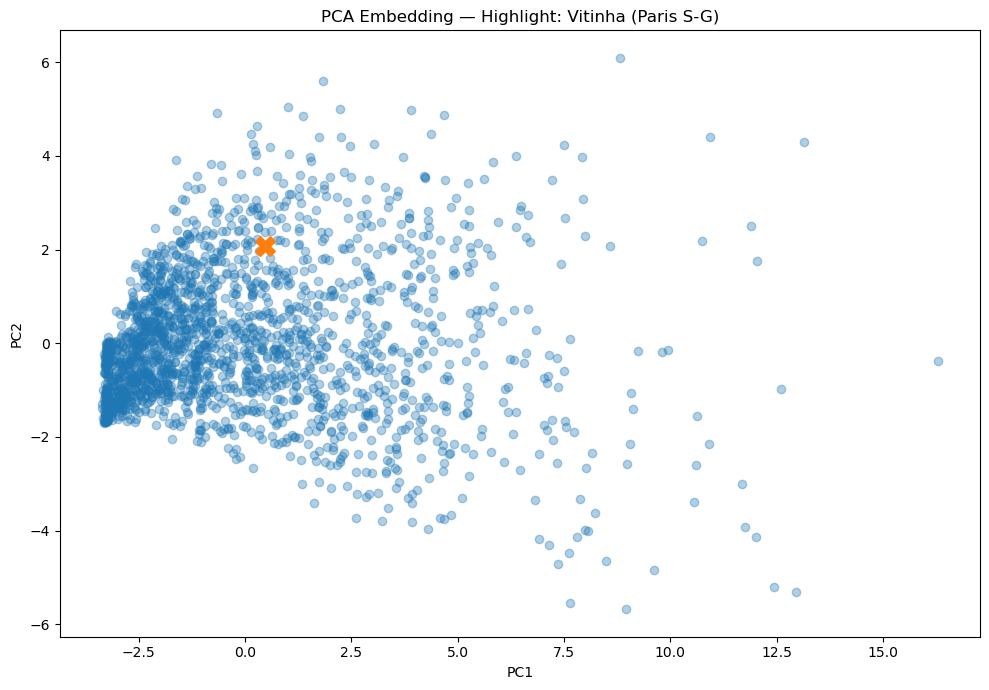

Saved PCA scatter to: C:\Users\User\Desktop\ai-projects\football-data-intelligence-lab\player-similarity\reports\figures\pca_scatter_Vitinha_Paris_S-G.png


In [8]:
# PCA scatter (PC1 vs PC2)
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

plt.figure(figsize=(10, 7))

# all players
plt.scatter(pc1, pc2, alpha=0.35)

# highlight selected player
plt.scatter(
    pc1[idx],
    pc2[idx],
    marker="X",
    s=200
)

plt.title(f"PCA Embedding — Highlight: {player_label}")
plt.xlabel("PC1")
plt.ylabel("PC2")

# save figure
pca_fig_path = FIG_DIR / f"pca_scatter_{row['Player'].replace(' ', '_')}_{row.get('Squad','').replace(' ', '_')}.png"
plt.tight_layout()
plt.savefig(pca_fig_path, dpi=200)
plt.show()

print("Saved PCA scatter to:", pca_fig_path)


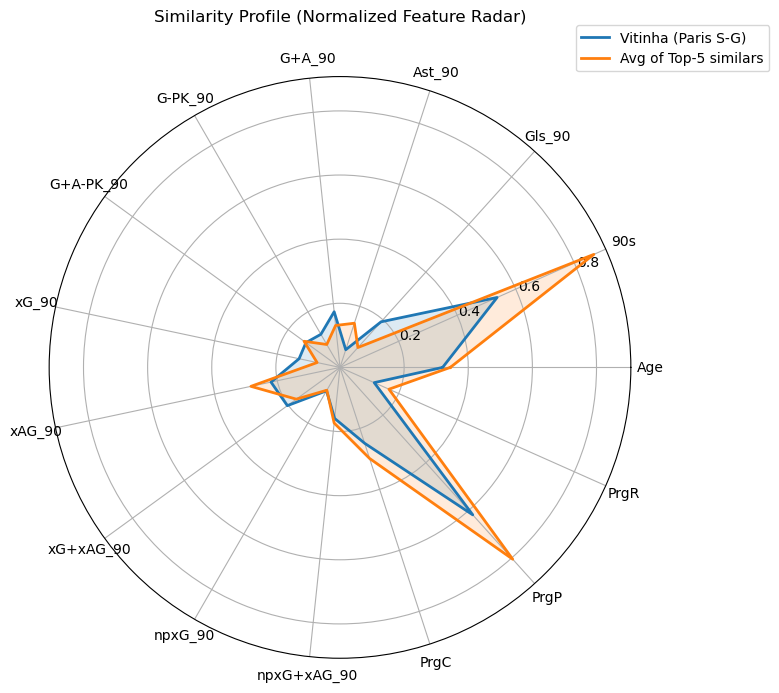

Saved radar chart to: C:\Users\User\Desktop\ai-projects\football-data-intelligence-lab\player-similarity\reports\figures\radar_Vitinha_Paris_S-G.png


In [9]:
def radar_plot(categories, values_a, values_b, label_a, label_b, title, save_path=None):
    # close the loop
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    values_a = values_a.tolist()
    values_b = values_b.tolist()

    angles += angles[:1]
    values_a += values_a[:1]
    values_b += values_b[:1]

    fig = plt.figure(figsize=(9, 7))
    ax = plt.subplot(111, polar=True)

    ax.plot(angles, values_a, linewidth=2, label=label_a)
    ax.fill(angles, values_a, alpha=0.15)

    ax.plot(angles, values_b, linewidth=2, label=label_b)
    ax.fill(angles, values_b, alpha=0.15)

    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_title(title, y=1.08)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200)
    plt.show()


K_RADAR = 5
topk_indices = sim_df["pca_index"].head(K_RADAR).astype(int).tolist()

player_scaled = X_scaled[idx]
topk_scaled_mean = X_scaled[topk_indices].mean(axis=0)
mins = X_scaled.min(axis=0)
maxs = X_scaled.max(axis=0)
den = np.where((maxs - mins) == 0, 1.0, (maxs - mins))

player_01 = (player_scaled - mins) / den
topk_01 = (topk_scaled_mean - mins) / den

radar_fig_path = FIG_DIR / f"radar_{row['Player'].replace(' ', '_')}_{row.get('Squad','').replace(' ', '_')}.png"

radar_plot(
    categories=features,
    values_a=player_01,
    values_b=topk_01,
    label_a=player_label,
    label_b=f"Avg of Top-{K_RADAR} similars",
    title="Similarity Profile (Normalized Feature Radar)",
    save_path=radar_fig_path
)

print("Saved radar chart to:", radar_fig_path)
